# I] Import, options

In [1]:
import numpy, seaborn, pandas
import matplotlib, matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams.update({'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                            'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',
                            'figure.figsize':(8, 5), 'svg.fonttype' : 'none'})

In [3]:
file_directory = "/Users/kja11/OneDrive - Menntaský/PostDoc_Hypothermia/in_silico/Python/"

# II] Data Download

In [4]:
#data HEK293 all H3K4me3
df = pandas.read_csv(file_directory+'1) input/HEK293_H3K4me3_32wtvs37wt.csv',sep = ',')

# select columns
columns = ['SYMBOL','Fold','FDR','annotation']
print(df.shape)
df[columns].head(5)

(177130, 37)


,SYMBOL,Fold,FDR,annotation
0,SMURF2,9.736071,6.661150e-11,Promoter (<=1kb)
1,ADGRB3,-22.212075,6.661150e-11,"Intron (ENST00000370598.6/577, intron 20 of 31)"
2,CFAP418-AS1,-22.192065,6.661150e-11,"Intron (ENST00000671532.1/100616530, intron 3 ..."
3,NMD3,-22.108883,6.661150e-11,"Intron (ENST00000468606.5/51068, intron 2 of 5)"
4,CDH12,-22.033656,6.661150e-11,"Intron (ENST00000504376.6/1010, intron 2 of 13)"


In [5]:
#p.value is probably not adj.p.value

# III] VolcanoPlot

In [6]:
#define the colors
df = df[df['FDR'] < 1]
print(df.shape)
colors = ['blue' if x < -5 and -numpy.log10(y) > 5
          else 'red' if x > 5 and -numpy.log10(y) > 5
          else 'black' if x > -1 and x < 1
          else 'grey' for x, y in zip(df['Fold'], df['FDR'])]

blue_indices = [symbol for symbol, color in zip(df['SYMBOL'], colors) if color == 'blue']
red_indices = [symbol for symbol, color in zip(df['SYMBOL'], colors) if color == 'red']
grey_indices = [symbol for symbol, color in zip(df['SYMBOL'], colors) if color == 'grey']

blue_genes_n = len(set(blue_indices))
red_genes_n = len(set(red_indices))
grey_genes_n = len(set(grey_indices))

(12759, 37)


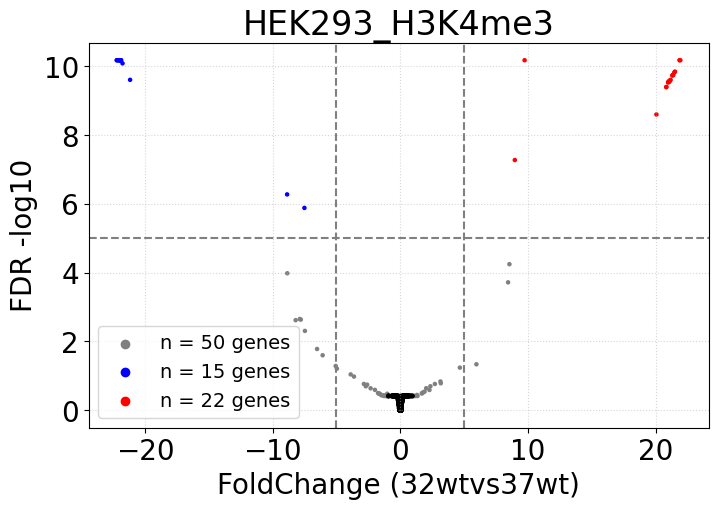

In [26]:
#volcano plot
# Plot, after convertion  y to log10(pvalue)
plt.scatter(x=df['Fold'],y=df['FDR'].apply(lambda x:-numpy.log10(x)),
            s=5,  c=colors)

plt.scatter(x=[],y=[], marker="o", color='grey', label= f'n = {grey_genes_n} genes')
plt.scatter(x=[],y=[], marker="o", color='blue', label= f'n = {blue_genes_n} genes')
plt.scatter(x=[],y=[], marker="o", color='red', label= f'n = {red_genes_n} genes')

plt.legend(fontsize = '14')
plt.title('HEK293_H3K4me3') 
plt.xlabel("FoldChange (32wtvs37wt)")
plt.ylabel("FDR -log10")

plt.axvline(-5,color="grey",linestyle="--")
plt.axvline(5,color="grey",linestyle="--")
plt.axhline(5,color="grey",linestyle="--")

title_file = 'volcano_HEK293_H3K4me3_32wtvs37wt'
# plt.savefig(file_directory+'3) output/'+title_file+'.svg')

## IV] Heatmap

In [8]:
df.shape

(12759, 37)

In [9]:
#select the interesting genes
df_hm = df[ (df['Fold'] > 5) | (df['Fold'] < -5) ]

log_p_value = 5
p_value = 10**(-log_p_value)

df_hm = df_hm[ (df_hm['p.value'] < p_value) ]
print(f"highest pvalue is {df_hm['p.value'].max()}")

df_hm = df_hm[['SYMBOL', 'Fold','p.value']]
print(df_hm.shape)
# save this results
df_hm.to_csv('{}/1) input/from_output/highest_HEK293_H3K4me3_32wtvs37wt.csv'.format(file_directory), sep=',')
df_hm.head()

highest pvalue is 8.28675898512697e-06
(43, 3)


,SYMBOL,Fold,p.value
0,SMURF2,9.736071,6.772161e-15
1,ADGRB3,-22.212075,3.090996e-14
2,CFAP418-AS1,-22.192065,3.260255e-14
3,NMD3,-22.108883,4.067225e-14
4,CDH12,-22.033656,4.964745e-14


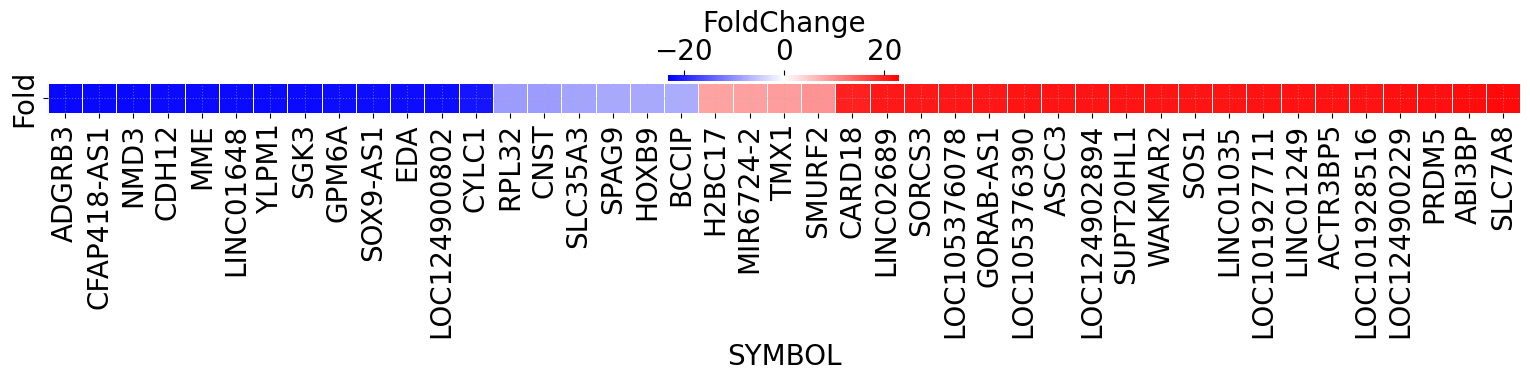

In [10]:
data = df_hm[['SYMBOL','Fold']]
data = data.sort_values(['Fold'], ascending = True)
data.set_index('SYMBOL', inplace= True)

plt.subplots(figsize=(19,0.5))
seaborn.heatmap(data.T, annot=False, cmap="bwr", linewidths=.5, center=0, vmin=-23, vmax=23,
               cbar_kws={'label': 'FoldChange', 'location' : 'top', 'orientation': 'horizontal',
                        'aspect': 40})

title_file = 'Heatmap_HEK293_H3K4me3_32wtvs37wt'
plt.savefig(file_directory+'3) output/'+title_file+'.svg')

In [11]:
# save the list to csv
df_hm.sort_values(['Fold'], ascending = True)
df_hm.to_csv('{}/1) input/from_output/HEK293_H3K4me3_32wtvs37wt_topgenes.csv'.format(file_directory), 
             index= False, sep=',')

# V] Classification by annotation

In [12]:
#to see the different kind of annotation 
# set(df.annotation)

In [13]:
# create a function to simplufy the annotation
def get_annotation_category(annotation):
    if annotation.startswith('Intron'):
        return 'Intron'
    elif annotation.startswith('Exon'):
        return 'Exon'
    elif annotation.startswith('Promoter'):
        return 'Promoter'
    else:
        return annotation

In [14]:
df = df.assign(Annotation = df['annotation'].apply(get_annotation_category))
df = df[['SYMBOL', 'Fold', 'p.value', 'FDR', 'Annotation']]
print(set(df.Annotation), '\n')

df['Annotation'] = df['Annotation'].str.strip()
df

{'Promoter', "5' UTR", "3' UTR", 'Exon', 'Downstream (<=300bp)', 'Intron', 'Distal Intergenic'} 



,SYMBOL,Fold,p.value,FDR,Annotation
0,SMURF2,9.736071e+00,6.772161e-15,6.661150e-11,Promoter
1,ADGRB3,-2.221207e+01,3.090996e-14,6.661150e-11,Intron
2,CFAP418-AS1,-2.219206e+01,3.260255e-14,6.661150e-11,Intron
3,NMD3,-2.210888e+01,4.067225e-14,6.661150e-11,Intron
4,CDH12,-2.203366e+01,4.964745e-14,6.661150e-11,Intron
...,...,...,...,...,...
12754,ACADM,1.891708e-06,9.998260e-01,9.999782e-01,Intron
12755,NUP153-AS1,4.333402e-07,9.998519e-01,9.999782e-01,Promoter
12756,UACA,-1.508212e-06,9.998604e-01,9.999782e-01,Promoter
12757,PROM1,-8.636477e-07,9.999206e-01,9.999782e-01,Intron


In [15]:
df.Annotation.value_counts()

Promoter                9174
Intron                  2063
Distal Intergenic       1258
Exon                     160
3' UTR                    88
5' UTR                    11
Downstream (<=300bp)       5
Name: Annotation, dtype: int64

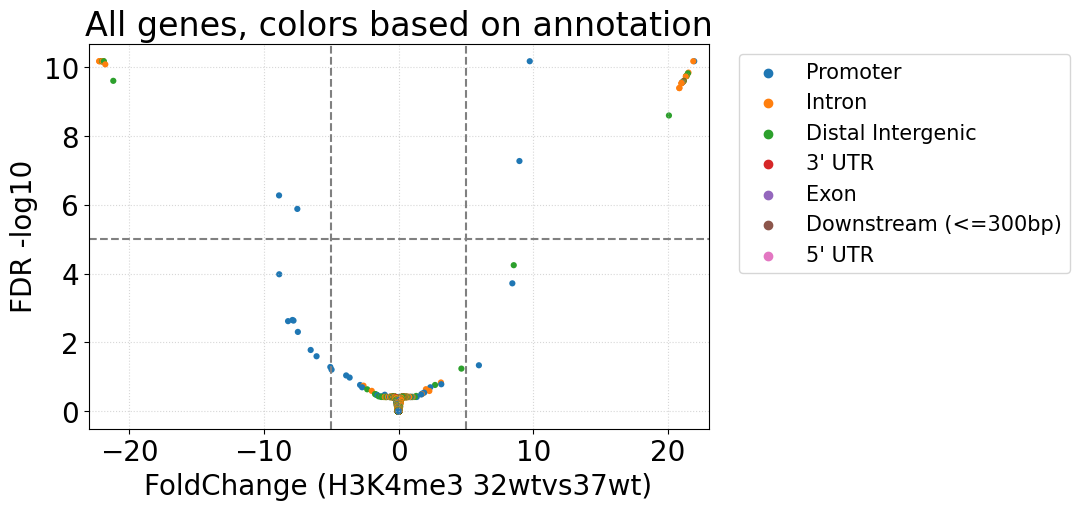

In [22]:
seaborn.scatterplot(data=df, x=df['Fold'], 
                    y=df['FDR'].apply(lambda x:-numpy.log10(x)), 
                    s=20, edgecolor='none', hue="Annotation")

plt.legend(loc='upper right', bbox_to_anchor=(1.60, 1), fontsize='15')

plt.title('All genes, colors based on annotation')
plt.xlim(-23, 23)
plt.xlabel("FoldChange (H3K4me3 32wtvs37wt)")
plt.ylabel("FDR -log10")

plt.axvline(-5,color="grey",linestyle="--")
plt.axvline(5,color="grey",linestyle="--")
plt.axhline(5,color="grey",linestyle="--")

title_file = 'volcano_HEK293_H3K4me3_32wtvs37wt_all_annotation'
plt.savefig(file_directory+'3) output/'+title_file+'.svg')

In [23]:
# Check up to see if its true (yes, the colors fit to the annotation)
log_p_value = 5
p_value = 10**(-log_p_value)

df_ctl = df[ (df['Fold'] > 1) & (df['FDR'] < p_value)]
df_ctl.sort_values('Fold').head()

,SYMBOL,Fold,p.value,FDR,Annotation
34,TMX1,8.970507,1.498655e-10,5.316062e-08,Promoter
0,SMURF2,9.736071,6.772161e-15,6.661150e-11,Promoter
33,CARD18,20.062477,6.907704e-12,2.520325e-09,Distal Intergenic
32,LINC02689,20.831570,1.071616e-12,4.024862e-10,Intron
31,SORCS3,20.838367,1.036618e-12,4.011396e-10,Intron


In [24]:
import scipy, scipy.stats

In [25]:
# Create a DataFrame
# Calculate Pearson correlation coefficient between p-value and annotation encoding
r_value, p_value = scipy.stats.spearmanr(df['FDR'], df['Annotation'])

print(f'Correlation coefficient: {r_value}')
print(f'P-value: {p_value}')

Correlation coefficient: 0.3639545606300531
P-value: 0.0
